In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [12]:
SEED = 42 # We prevent the code to be generated randomly in order to have the same result each time we run the code.
np.random.seed(SEED) #This used for Numpy.
tf.random.set_seed(SEED) # This is used for Tensorflow.

print(tf.__version__) # Making sure everything is loaded.

2.20.0


In [23]:
BATCH_SIZE = 64 # We keep this at 64 in order to have a balance between CPU and GPU, note that 64 is still considered to be large.
EPOCHS = 30 # Number of times we try to re-train the model over the train data we have.
LR = 1e-3 # Usual learning rate start point for ADAM.

MODEL_DIR = "saved_model" # This is a folder which we will save the trained model inside.
BEST_WEIGHTS_PATH = os.path.join(MODEL_DIR, 'best_weights.weights.h5') # We save best weights in order to use them again.
os.makedirs(MODEL_DIR, exist_ok=True) # We will try to create the folder and if it existed already, we wont have errors.

In [14]:
(x_train , y_train), (x_test, y_test) = keras.datasets.cifar10.load_data() # We load the CIFAR-10 dataset from Keras.

num_classes = 10 # We have 10 items in the dataset hence why we enter 10 as we will have 10 classes and outcomes.
input_shape = (32, 32, 3) # This is the image size (32x32), with 3 channels: height - width - color (3 channels since it's not B&W).

x_train = x_train.astype('float32') / 255.0 # We noremalize the data and make sure it remains float by adding .0 since we don't want rounded numbers.
x_test = x_test.astype('float32') / 255.0

y_train = y_train.reshape(-1) # We make the data from 2D to 1D, in other words we flatten them from [1] which has 2 dimentions, after this, it will be 1 instead of [1].
y_test = y_test.reshape(-1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape) # We check the shapes to be sure everything is fine.

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


In [16]:
# This part is mainly for overfitting prevention since we have only 50,000 samples.
# Therefore, after each train, we change the picture slightly so the model learns that the content of the picture is important rather than the pixels.

data_augmentation = keras.Sequential( # We create a layer which acts as a filter which randomly changes something in the picture.
    [
    layers.RandomFlip("horiozontal", seed=SEED),
    layers.RandomRotation(0.08, seed=SEED),
    layers.RandomZoom(0.1, seed=SEED),
    ],
    name = 'augment' # This will add a section to summary method since we can track the augmentation part.
)
data_augmentation.summary() # Numbers of parameters are 0 because they don't learn anything and change the picture only.

Model: "augment"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
def build_model():
    inputs = keras.Input(shape=input_shape) # This is the input of our NN, which is (32, 32, 3).

    x = data_augmentation(inputs) # We apply this filter randomly while training only.

    # First layer which extracts basic details.
    x = layers.Conv2D(32, 3, padding="same")(x) # We apply 32 filters with the size of 3x3, with padding we keep the HW the same on both training and output.
    x = layers.BatchNormalization()(x) # We normalize each batch which is 32 here.
    x = layers.Activation("relu")(x) # This makes the negative values zero and makes it non-linear.
    x = layers.Conv2D(32, 3, padding="same")(x) # This layer catches more detiled aspects such as edges, etc.
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D()(x) # We reduce the size from 32x32 to 16x16 in order to reduce the training time and also focus on more important aspects of the picture.
    x = layers.Dropout(0.25)(x) # We prevent overfitting by disabling 25% of neurons.

    # In this block, we increase the filters from 32 to 64 in order to identify more complex patters such as harmony of items, etc.
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.35)(x) # Since this layer is deeper, we disble 35% now to prevent overfitting.

    # Extracting deep and complex features, for example telling apart car from wheels or legs from cat.
    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x) # Again more dropout to prevent overfitting.

    x = layers.Flatten()(x) # The output which is (H, W, C) will be converted to an 1D vector which includes every extracted detail.
    x = layers.Dense(256)(x) # A fully connected NN with 256 neurons, here the model learns which features are the best to identify the class of the given object, the number of neurons must be something which prevents boh under and overfitting.
    x = layers.BatchNormalization()(x) # We normalize the output of each nueron to keep them in the ideal area with variance of 1 and the average to 0.
    x = layers.Activation("relu")(x) # We make the model non-linear so it can learn complex connection between features.
    x = layers.Dropout(0.5)(x) # We disable 50% of the neurons in order to make sure we don't rely on a specefic feature.

    outputs = layers.Dense(num_classes, activation="softmax")(x) # This activation function will return the class of the image, we have 10 neurons since we have 10 diffrent classes.
    model = keras.Model(inputs, outputs, name="cnn_cifar10") # This will connect the input and output neurons to have a complete model, the name is just for summary method.
    return model

model = build_model() # We create the NN model which we just made.
model.summary() # This shows the NN structure, number of parameters which is the amount of samples the model learns during training phase and also the shape of each layer.
# You can see as we go down and the nuber of filters are increasing, we have more parameters.

Model: "cnn_cifar10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 816,938 (3.12 MB)

 Trainable params: 815,530 (3.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [19]:
# Here we set the settings for training phase of our model.
model.compile(
    optimizer = keras.optimizers.Adam(LR), # This is the brain of our model which updates the weights based on loss.
    loss = keras.losses.SparseCategoricalCrossentropy(), # This part helps optimizer to update the weights to get the correct class, we use Sparse since the model returns a simple number such as 5 rather than (0, 0, 0, 0, 1, 0 ,0 ,0 ,0, 0) which in this case we would use CategoricalCrossEntropy if it was one-hot encoding.
    metrics=['accuracy'] # This line will report the performance during the training, this part only shows us the performance and doesn't affect the training process
)

In [21]:
val_ratio = 0.1 # We keep 10% of the training data for validation.
val_size = int(x_train.shape[0] * val_ratio) # This multiplies the total amount of data we have which is 50,000 here by the ratio, therefore, we get 5,000.

x_val, y_val = x_train[:val_size], y_train[:val_size] # The first 5000 pictures for validation during the training after each epoch.
x_trn, y_trn = x_train[val_size:], y_train[val_size:] # The rest of the images which are 45,000 and we use this to train the model.
# Note that we still have x_test which is 10,000.

# We convert the numpy data to tensorflow dataset which is more optimal.
# Shuffle will randomize the data during each epoch in order to prevent for example all of the cat images to enter the NN at the same time, here we save 40,000 images in each shuffle.
# The batch will group the images in smaller mini-training steps in order to prevent the model from seeing everything a the same time hence it is faster.
# We prefetch in order to prepare the next batch while the current one is being trained in order to prevent the GPU from being idle and autotune will allow TF to set the best value for amount of prefetched data.
# THE ORDER OF THE ACTIONS WE DID IS IMPORTANT!
train_ds = tf.data.Dataset.from_tensor_slices((x_trn, y_trn)).shuffle(40000, seed=SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# We do not need shuffle for test and validation since order is not important since have passed the training.
# We only apply batch and prefeth for speed and performance reasons.
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(len(list(train_ds)), len(list(val_ds)), len(list(test_ds))) # This returns the number batches in each dataset.

704 79 157


2025-10-24 21:38:04.140211: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [24]:
# With callbacks, we manage and optimize the traing behavior of the model.
# They can be executed after certain time for example after each epoch and change things such as LR or stop the training.
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True), # This stops the training process if the model doesn't improve performance on validation ds after 6 epochs, this is in order to prevent overfitting.
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6), # This will reduce the LR in case the model can't improve loss after 3 epochs.
    ModelCheckpoint(BEST_WEIGHTS_PATH, monitor='val_accuracy', save_best_only=True, save_weights_only=True) # This saves the best trained model based on the defined qualities during the training phase
]
# The callbacks above will:
# Prevent overfitting
# Get the model to best weights
# Save the best weights

In [25]:
# In this part, everything we prepared will be mixed together in order to train the model.
history = model.fit(
    train_ds, # This is the training dataset which we made, for each batch: It predicts (forward pass), calculates loss, calculates the gradians (backpropagation), updates weights using optimizer.
    validation_data=val_ds, # We validate the model after each epoch with validation data.
    epochs=EPOCHS, # Number of total epochs but may stop earlier due to callbacks.
    callbacks=callbacks, # Callbacks will be checked after each epoch.
    verbose=2 # The amount of data we want to see about each epoch, 0 is disabled, 1 is with progress bar, 2 is detailed version.
)

Epoch 1/30
704/704 - 58s - 82ms/step - accuracy: 0.3853 - loss: 1.7250 - val_accuracy: 0.4534 - val_loss: 1.4857 - learning_rate: 1.0000e-03
Epoch 2/30
704/704 - 56s - 80ms/step - accuracy: 0.5234 - loss: 1.3249 - val_accuracy: 0.5744 - val_loss: 1.1714 - learning_rate: 1.0000e-03
Epoch 3/30
704/704 - 56s - 80ms/step - accuracy: 0.5837 - loss: 1.1718 - val_accuracy: 0.6488 - val_loss: 1.0240 - learning_rate: 1.0000e-03
Epoch 4/30
704/704 - 56s - 79ms/step - accuracy: 0.6216 - loss: 1.0666 - val_accuracy: 0.6654 - val_loss: 0.9822 - learning_rate: 1.0000e-03
Epoch 5/30
704/704 - 55s - 79ms/step - accuracy: 0.6515 - loss: 0.9954 - val_accuracy: 0.6576 - val_loss: 1.0411 - learning_rate: 1.0000e-03
Epoch 6/30
704/704 - 55s - 78ms/step - accuracy: 0.6701 - loss: 0.9437 - val_accuracy: 0.6922 - val_loss: 0.8550 - learning_rate: 1.0000e-03
Epoch 7/30
704/704 - 55s - 78ms/step - accuracy: 0.6826 - loss: 0.9046 - val_accuracy: 0.7106 - val_loss: 0.8130 - learning_rate: 1.0000e-03
Epoch 8/30
70

In [26]:
# Here we make sure that the model uses best weights rather than the random weights of the last epoch.
# The weights are the exact number which the model actually learns and the learning is stored in them.
# The best weights are being saved via callbacks.
if os.path.exists(BEST_WEIGHTS_PATH):
    model.load_weights(BEST_WEIGHTS_PATH) # We load weights since we only stored them and we didn't save the model itself.
    print("Loaded best weights.")
else:
    print("Best weights file not found, therefore, using current model parameters.")

# Note that in EarlyStopping we defined restore_best_weights as True, therefre, the model loads the best weights automatically after the final epoch and this cell is to make sure everything is fine.

Loaded best weights.


In [27]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0) # The evaluate function sends the dataset batch by batch to the model just like fit but it doesn't update the weights and returns the ouput only.
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

y_pred_probs = model.predict(test_ds, verbose=0) # This method the class of each test subject, since we have 10 classes, it returns 10 diffrent classes.
y_pred = np.argmax(y_pred_probs, axis=1) # We only store the number of the class with highest probability, for example [3, 2, 5, ...]

print("Classification report:\n", classification_report(y_test, y_pred, digits=4)) # Full detailed report using sklearn, we use y_test instead of test_ds since classification_report needs a simple array.
cm = confusion_matrix(y_test, y_pred) # This is to see where the model is making mistakes.
print(cm[:5, :5])

Test accuracy: 0.8252 | Test loss: 0.5162
Classification report:
               precision    recall  f1-score   support

           0     0.8132    0.8750    0.8430      1000
           1     0.9164    0.9210    0.9187      1000
           2     0.7765    0.7680    0.7722      1000
           3     0.8121    0.5920    0.6848      1000
           4     0.7960    0.7880    0.7920      1000
           5     0.8428    0.6860    0.7563      1000
           6     0.7177    0.9430    0.8150      1000
           7     0.8538    0.8820    0.8677      1000
           8     0.8914    0.8950    0.8932      1000
           9     0.8623    0.9020    0.8817      1000

    accuracy                         0.8252     10000
   macro avg     0.8282    0.8252    0.8225     10000
weighted avg     0.8282    0.8252    0.8225     10000

[[875   9  34   4   8]
 [  8 921   0   0   2]
 [ 50   3 768   9  42]
 [ 23   4  59 592  54]
 [ 10   2  49  10 788]]


In [ ]:
# Here we visualize the performance to check whether the model is well-trained or not.
def plot_history(hist):
    # History method stores full details regarding the trining phase during each epoch.
    acc = hist.history["accuracy"] # Accuracy of the training set.
    val_acc = hist.history["val_accuracy"] # Accuracy of the validation set.
    loss = hist.history["loss"] # Loss of the training set.
    val_loss = hist.history["val_loss"] # Loss of the validation set.

    # This is matplotlib.
    plt.figure()
    plt.plot(acc, label="train_accuracy")
    plt.plot(val_acc, label="val_accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy over epochs")
    plt.show()

    # This is matplotlib.
    plt.figure()
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss over epochs")
    plt.show()

plot_history(history) # This is the model we have trained, it's the name.

# What we want is both lines going up together for accuracy and down for loss.
# If the train accuracy goes up while validation accuracy goes down or remains the same, it means we have overfitting.
# If the train loss goes down while validation accuracy goes up or remains the same, it means we have overfitting.
# If the loss doesn't change, we need a new LR.
# If both accuracies are low, we have underfit.
# If we have too much noise in validation, the batch size might be small or validation data might not be enough.

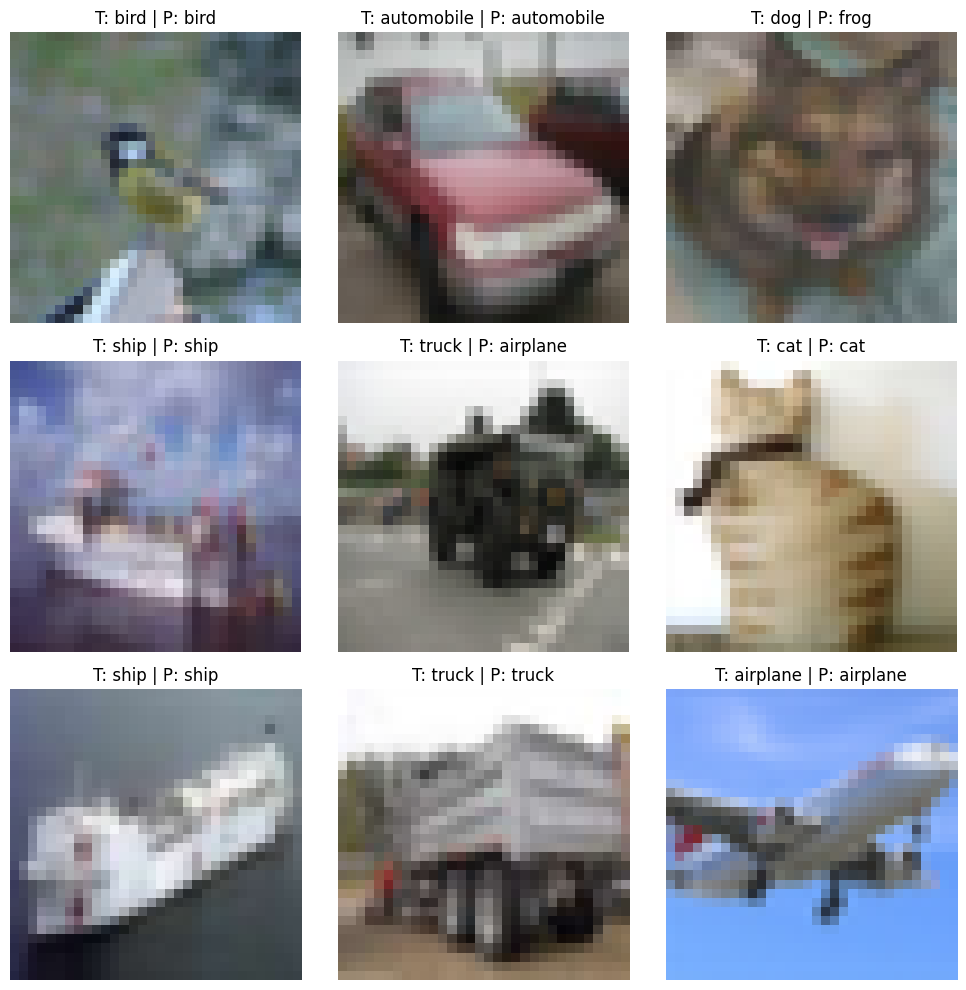

In [29]:
# Here we see couple of test samples and the output of the model to see the prdiction.
# Here we see by our own eyes where the model made a mistake rather than just seeing the numbers.
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

def show_predictions(images, labels, preds, n=9):
    idxs = np.random.choice(len(images), size=n, replace=False)
    plt.figure(figsize=(10,10))
    for i, idx in enumerate(idxs):
        plt.subplot(3,3,i+1)
        plt.imshow(images[idx])
        true_c = class_names[labels[idx]] # The actual class of the picture.
        pred_c = class_names[preds[idx]] # The predicted class of the picture.
        plt.title(f"T: {true_c} | P: {pred_c}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_predictions(x_test, y_test, y_pred, n=9)

In [31]:
# We save the full model rather than only the weights.
# This includes the weights, the NN architecture, optimizer and class compile settings.
FULL_MODEL_PATH = os.path.join(MODEL_DIR, "cnn_cifar10.keras")
model.save(FULL_MODEL_PATH)
print(f"Model saved to: {FULL_MODEL_PATH}")

Model saved to: saved_model/cnn_cifar10.keras


In [40]:
# Here we test the model on our own picture to see the results.
from tensorflow.keras.utils import load_img, img_to_array
# load_img: Reads the image and returns it as PIL image.
# img_to_array: Converts the image to a Numpy array.

def predict_image(img_path):
    img = load_img(img_path, target_size=input_shape[:2]) # We resize the image to expected size of the model which is 32x32 here.
    arr = img_to_array(img).astype("float32") / 255.0 # We normalize the data and make sure they are float so they are not rounded.
    arr = np.expand_dims(arr, axis=0) # We add a batch since the model is expecting a batch so we convert (32, 32, 3) to (1, 32, 32, 3) since we only have 1 image but keras still needs the batch number.
    probs = model.predict(arr, verbose=0)[0] # This will return the class of the given image since the last layer had softmax activator.
    pred_idx = int(np.argmax(probs)) # We get the class with highest chance.
    return class_names[pred_idx], float(np.max(probs))

label, conf = predict_image('img2.jpg') # The images are in the root folder of the project.
print(label, conf)

frog 0.8138527870178223
